In [1]:
sys.path.append('/Users/jacoblourie')

In [243]:
import tensorflow as tf
import sys
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
#From my own library
from computer_vision.my_lib.blur_contrast import display_image
import pandas as pd

## Trying to build a full 3 layer neural net from scratch using MNIST data

In [244]:
#Load the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


#need to make it smaller though
# x_train = x_train[0:10000]
# y_train = y_train[0:10000]

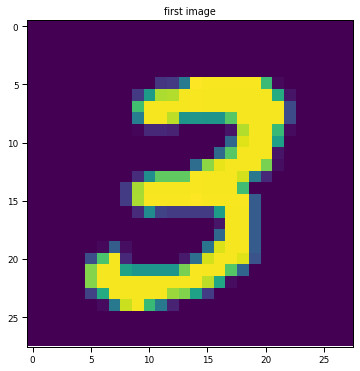

In [629]:
#see what an image looks like
display_image(x_train[7],'first image', size=(6,6))

## To make this simple, we will start by runnin a "is it a 1? " model 
We want to run a 1/0 model, so let's label all "1"s as 1, and everything else as 0

In [246]:
binary_y_train = np.array([1 if y == 1 else 0 for y in y_train])
binary_y_test = np.array([1 if y == 1 else 0 for y in y_test])

Let's go for 2 hidden layers, of 50 and 50 levels and let's just use sigmoid functions for now

In [290]:
#this helps much simpler
def flatten_and_reshape(x_train,x_test, y_train, y_test):

    x_train_flat = x_train.reshape((x_train.shape[0],-1)).T / 255
    x_test_flat = x_test.reshape((x_test.shape[0],-1)).T / 255
    print(x_train_flat.shape)
    bin_y_train = y_train.reshape(1,-1)
    bin_y_test = y_test.reshape(1,-1)
    return x_train_flat, x_test_flat, bin_y_train, bin_y_test

x_train_flat, x_test_flat, bin_y_train, bin_y_test = flatten_and_reshape(x_train, x_test, binary_y_train, binary_y_test)

#Create the binary model

# y_train_transp = y_train.reshape(1,-1) 
# y_test_transp = y_test.reshape(1,-1)



(784, 60000)


We'll go with a Gaussian initialisation of matrices

In [291]:
#Let's create the 'weights' matrices
def init_weights(x_train_flat, layer_1, layer_2,output):
    np.random_state = 112
    layer_1 = layer_1
    layer_2 = layer_2
    size_of_layer = [x_train_flat.shape[0], layer_1,layer_2, output]
    dict_of_weights = {}

    for layer in range(len(size_of_layer) - 1):
        dict_of_weights[f"W{layer+1}"] = np.random.randn(size_of_layer[layer+1],size_of_layer[layer])
        dict_of_weights[f"B{layer+1}"] = np.random.randn(size_of_layer[layer+1],1)
    #Print the sizes of the matrix
    print(f"Weights matrices")
    for name, matrix in dict_of_weights.items():
        print(name, matrix.shape)
    return dict_of_weights

dict_of_weights = init_weights(x_train_flat, 50, 15, 1)

Weights matrices
W1 (50, 784)
B1 (50, 1)
W2 (15, 50)
B2 (15, 1)
W3 (1, 15)
B3 (1, 1)


## To start with, let's do sigmoid activation for each layer

In [623]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

dict_of_FP_values = {}
#FORWARD PROPOGATION
def sigmoid_forward_prop(previous_a, W, B):
    Z = W @ previous_a + B
    next_A = sigmoid(Z)
    return Z, next_A

def forward_prop(dict_of_weights,x_train_flat,bin_y_train):
    W1, B1, W2, B2, W3, B3 = dict_of_weights.values()
    
    Z1, A1 = sigmoid_forward_prop(x_train_flat, W1, B1)
    Z2, A2 = sigmoid_forward_prop(A1, W2, B2)    
    Z3, A3 = sigmoid_forward_prop(A2, W3, B3)
    
    dict_of_FP_values['Z1'] = Z1
    dict_of_FP_values['A1'] = A1
    dict_of_FP_values['Z2'] = Z2
    dict_of_FP_values['A2'] = A2
    dict_of_FP_values['Z3'] = Z3
    dict_of_FP_values['A3'] = A3
    
    Cost = ((bin_y_train - A3) @ np.transpose(bin_y_train - A3) / A3.size )[0]

    return dict_of_FP_values, Cost

dict_of_FP_values, Cost = forward_prop(dict_of_weights,x_train_flat,bin_y_train)

## Great, so now we need to do back propogation.



Worth nothing, that everything is positive - this kind of makes sense because right now the dumb model can be improved by just setting everything to 0 (as only 10% of outputs are "1")

Let's keep going back through the differentials

In [624]:
differentiat_dict = {} #putting this here for later

In [625]:
def back_prop_one_layer_from_A_to_previous_A(cost_of_that_A, Z, prev_A,W):    
        #going back from A to z
        dAn_dZn = np.exp(-Z) / ((1+np.exp(-Z))**2)
        dC_dZn = cost_of_that_A * dAn_dZn
        
        #get diffs at that layer
        dZn_dWn = prev_A
        dZn_dBn = np.zeros_like(Z) + 1

        #combien to get useful differentials
        dC_dWn = dC_dZn @ dZn_dWn.T / Z.size
        dC_dBn = np.sum(dC_dZn @ dZn_dBn.T,axis=1,keepdims=True) / dZn_dBn.shape[1]

        #and then get the previous layer cost fuctions
        dZn_dA_minus_one = W
        dC_dA_minus_one = (dC_dZn.T @ dZn_dA_minus_one).T

        return dC_dWn, dC_dBn, dC_dZn, dC_dA_minus_one

def back_prop(dict_of_weights, dict_of_FP_values, bin_y_train, x_train_flat):
    W1, B1, W2, B2, W3, W3 = dict_of_weights.values()
    Z1, A1, Z2, A2, Z3, A3 = dict_of_FP_values.values()
    
    differentiat_dict = {}
    
    '''Let's look at W3 and B3 first'''
    
    #This line is unique
    dC_dA3 = 2*(A3 - bin_y_train) #gives 1 by m matrix

    #do the back props
    dC_dW3, dC_dB3, dC_dZ3, dC_dA2 = back_prop_one_layer_from_A_to_previous_A(dC_dA3, Z3, A2, W3)
    dC_dW2, dC_dB2, dC_dZ2, dC_dA1 = back_prop_one_layer_from_A_to_previous_A(dC_dA2, Z2, A1, W2)
    dC_dW1, dC_dB1, dC_dZ1, dC_dA0 = back_prop_one_layer_from_A_to_previous_A(dC_dA1, Z1, x_train_flat, W1)

    differentiat_dict['dW1'] = dC_dW1
    differentiat_dict['dB1'] = dC_dB1
    differentiat_dict['dW2'] = dC_dW2
    differentiat_dict['dB2'] = dC_dB2
    differentiat_dict['dW3'] = dC_dW3
    differentiat_dict['dB3'] = dC_dB3

    return differentiat_dict

differentiat_dict = back_prop(dict_of_weights, dict_of_FP_values, bin_y_train, x_train_flat)

In [288]:
dict_of_FP_values['Z3'].size

12665

## Great stuff, now we need to update the weights.

In [252]:
def gradient_descent(learning_rate, dict_of_weights, differentiat_dict):
    
    #we have dictionaries for the weights and the differentials, which we should be able to use quite easily here. They are also in order so we can kind of cheat... but let's not 
    for key, value in dict_of_weights.items():
        dict_of_weights[key] += -learning_rate * differentiat_dict[f'd{key}']
    

## SO, now let's run this in a loop and see what happens to Cost

In [630]:
#We start with forward propogation, storing the cost
learning_rate = 0.1 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations = 250
cost = []

for iteration in range(iterations):
    
    dict_of_FP_values, Cost = forward_prop(dict_of_weights,x_train_flat,bin_y_train)
    cost.append(Cost[0]) #add cost to the list.
    #then, do back prop, storing the differentials
    differentiat_dict = back_prop(dict_of_weights, dict_of_FP_values, bin_y_train, x_train_flat)

    #then, do the gradient descent. Nothing stored, the weights just update and we re-use the new values in forward prop.
    gradient_descent(learning_rate, dict_of_weights, differentiat_dict)
    if iteration % 100 == 0:
        print(f'iteration: {iteration}\ncost: {Cost}')

iteration: 0
cost: [0.59158784]
iteration: 100
cost: [0.09616434]
iteration: 200
cost: [0.09593042]


/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

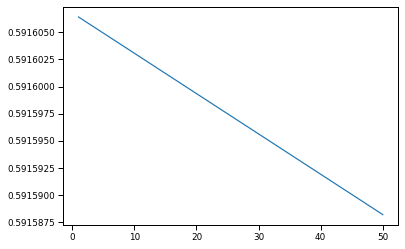

In [612]:
cost_x = np.linspace(1,iterations,iterations)
fig = plt.figure(figsize = (6,4))
sns.lineplot(cost_x,cost)


<AxesSubplot:ylabel='Count'>

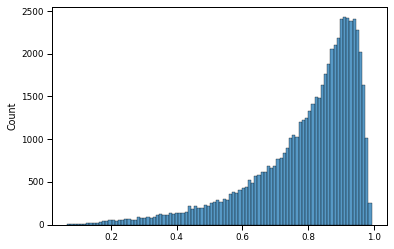

In [613]:
sns.histplot(dict_of_FP_values['A3'][0])

In [614]:
pd.Series(bin_y_train[0]).value_counts()

0    53258
1     6742
dtype: int64

In [615]:
pd.cut(pd.Series(dict_of_FP_values['A3'][0]), bins=10, right=False).value_counts()

[0.901, 0.994)    18303
[0.808, 0.901)    17211
[0.716, 0.808)    10172
[0.623, 0.716)     6060
[0.53, 0.623)      3520
[0.438, 0.53)      2159
[0.345, 0.438)     1276
[0.252, 0.345)      753
[0.16, 0.252)       447
[0.067, 0.16)        99
dtype: int64

## OK. It just seems to have optimised by making everything 0. Let's see what happens if we just have two numbers in the sample

In [579]:

def reduced_form(y_train,y_test, x_train, x_test, numbers):
    
    print(numbers)
    #Put in an array format
    y_train_arr_format = np.array(y_train)
    y_test_arr_format = np.array(y_test)

    y_train_df = pd.DataFrame( {'value': y_train_arr_format})
    train_index = y_train_df['value'].isin(numbers)

    #Repeat this for test
    y_test_df = pd.DataFrame( {'value': y_test_arr_format})
    test_index = y_test_df['value'].isin(numbers)

    #then get the relevant lists
    y_train_reduced = y_train_arr_format[train_index]
    x_train_reduced = x_train[train_index]
    y_test_reduced = y_test_arr_format[test_index]
    x_test_reduced = x_test[test_index]

    #flatten the shapes - note, we're not using x_test just yet, so can leave this as is.
    x_train_subset, x_test_subset, y_train_subset, y_test_subset = flatten_and_reshape(x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced)
    
    return x_train_subset, x_test_subset, y_train_subset, y_test_subset

numbers_looked_at = [1,2,3,4]

x_train_binary, x_test_binary, y_train_binary, y_test_binary = reduced_form(y_train, y_test, x_train, x_test, [1,0])

[1, 0]
(784, 12665)


In [634]:
#shows the split of class values
pd.Series(y_train_binary[0]).value_counts()

1    6742
0    5923
dtype: int64

In [640]:

#init the weights
dict_of_weights_2 = init_weights(x_train_binary, 50, 50, 1)
#then let's do some iterations
learning_rate = 0.1 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations = 1000
cost = []

for iteration in range(iterations):
    
    dict_of_FP_values_bin, Cost = forward_prop(dict_of_weights_2,x_train_binary,y_train_binary)
    cost.append(Cost[0]) #add cost to the list.
    #then, do back prop, storing the differentials
    differentiat_dict_bin = back_prop(dict_of_weights_2, dict_of_FP_values_bin, y_train_binary, x_train_binary)

    #then, do the gradient descent. Nothing stored, the weights just update and we re-use the new values in forward prop.
    gradient_descent(learning_rate, dict_of_weights_2, differentiat_dict_bin)
    if iteration % 30 == 0:
        print(Cost)


Weights matrices
W1 (50, 784)
B1 (50, 1)
W2 (50, 50)
B2 (50, 1)
W3 (1, 50)
B3 (1, 1)
[0.3022419]
[0.2006925]
[0.17360115]
[0.16354055]
[0.15645518]
[0.15021601]
[0.14446876]
[0.13913079]
[0.13416309]
[0.12953478]
[0.12521777]
[0.12118615]
[0.11741611]
[0.11388586]
[0.11057555]
[0.10746714]
[0.10454424]
[0.10179196]
[0.0991968]
[0.0967465]
[0.0944299]
[0.09223688]
[0.09015822]
[0.08818552]
[0.08631114]
[0.08452809]
[0.08282999]
[0.08121102]
[0.07966585]
[0.07818959]
[0.07677775]
[0.07542624]
[0.07413126]
[0.07288935]
[0.0716973]
[0.07055215]
[0.06945119]
[0.06839188]
[0.0673719]
[0.06638907]
[0.06544141]
[0.06452703]
[0.06364421]
[0.06279134]
[0.0619669]
[0.0611695]
[0.06039782]
[0.05965063]
[0.05892679]
[0.05822521]
[0.05754489]
[0.05688487]
[0.05624426]
[0.05562222]
[0.05501796]
[0.05443073]
[0.05385981]
[0.05330456]
[0.05276432]
[0.05223852]
[0.05172657]
[0.05122796]
[0.05074215]
[0.05026869]
[0.04980709]
[0.04935694]
[0.04891781]
[0.0484893]
[0.04807105]
[0.04766269]
[0.04726387]
[0

In [641]:
pd.cut(pd.Series(dict_of_FP_values_bin['A3'][0]), bins=10, right=False).value_counts()

[0.9, 1.001)       5070
[6.65e-05, 0.1)    4584
[0.8, 0.9)          852
[0.1, 0.2)          533
[0.7, 0.8)          453
[0.6, 0.7)          286
[0.2, 0.3)          276
[0.5, 0.6)          212
[0.3, 0.4)          206
[0.4, 0.5)          193
dtype: int64

Great - we have values at both ends of the spectrum!

/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

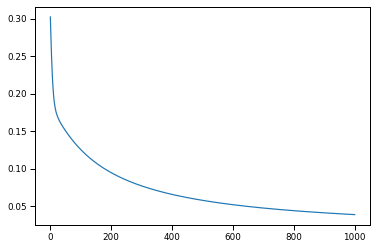

In [642]:
cost_x = np.linspace(1,iterations,iterations)
fig = plt.figure(figsize = (6,4))
sns.lineplot(cost_x,cost)

0.01 - what does this mean? it's the average of the sum of squared values. so on average the sum of the squared values is 0.01, which means the average modulus of the value is 0.1

## Next - let's use this to "Predict the Test Set"

In [645]:
def predict(vector_of_x, vector_of_y):
    FP_values, Cost = forward_prop(dict_of_weights_2,vector_of_x, vector_of_y)
    y_prob = FP_values['A3']
    #y_pred = round(FP_values['A3'])
    accuracy_vector = abs(y_prob - vector_of_y) < 0.5
    return y_prob,  accuracy_vector

prob, av = predict(x_test_binary, y_test_binary)

In [646]:
pd.Series(av[0]).value_counts()

True     2044
False      71
dtype: int64

## Alright, Let's move on to SoftMax function and try to predict correctly from all the numbers

We should also test the log versus non-logged form of the cost function, as the literature really supports the idea we should be using the logged form

In [670]:
#for y, we need to do some form of hot encoding.
from sklearn.preprocessing import OneHotEncoder

def create_one_hot_train_and_test(y_train, y_test):
    one_hot = OneHotEncoder(sparse = False)
    one_hot_y_train= one_hot.fit_transform(y_train.reshape(-1,1)).T ###currently doing it on two classes
    one_hot_y_test = one_hot.fit_transform(y_test.reshape(-1,1)).T
    return one_hot_y_train, one_hot_y_test
one_hot_y_train, one_hot_y_test = create_one_hot_train_and_test(y_train_binary, y_test_binary )

In [649]:
# let's see if we can initialise the weights
dict_of_weights_softmax = init_weights(x_train_binary, 50, 50, 2)

Weights matrices
W1 (50, 784)
B1 (50, 1)
W2 (50, 50)
B2 (50, 1)
W3 (2, 50)
B3 (2, 1)


## Gravy. Now let's take a look at the forward prop

One thing for sure is that we need to change the calculation of the cost function.

In [507]:
one_hot_y_train.shape

(10, 60000)

In [653]:
dict_of_FP_values_softmax = {}
#FORWARD PROPOGATION
def last_leg_softmax(previous_a, W, B):
    Z = W @ previous_a + B
    A = np.exp(Z)
    A = A / np.sum(A,axis=0) 
    return Z, A

def forward_prop_softmax(dict_of_weights,x_train,y_train_softmax):
    W1, B1, W2, B2, W3, B3 = dict_of_weights.values()
    Z1, A1 = sigmoid_forward_prop(x_train, W1, B1)
    Z2, A2 = sigmoid_forward_prop(A1, W2, B2)    
    Z3, A3 = last_leg_softmax(A2, W3, B3)
    
    dict_of_FP_values['Z1'] = Z1
    dict_of_FP_values['A1'] = A1
    dict_of_FP_values['Z2'] = Z2
    dict_of_FP_values['A2'] = A2
    dict_of_FP_values['Z3'] = Z3
    dict_of_FP_values['A3'] = A3
    
    #for cost fucntion, use the y log y_hat
    Cost = -np.sum(y_train_softmax * np.log(A3)) / y_train_softmax.shape[1]
    
    return dict_of_FP_values, Cost

dict_of_FP_values_softmax, Cost_softmax = forward_prop_softmax(dict_of_weights_softmax,x_train_binary,one_hot_y_train)

In [655]:
def back_prop_first_soft_max_layer(y_true, y_predicted, previous_A, Z, W):    
    #dC/dz first layer is just y - ÿ
    dC_dZ_final = y_predicted - y_true

    #get diffs at that layer
    dZfinal_dW = previous_A
    dZfinal_dB = np.zeros_like(Z) + 1

    #combine to get useful differentials
    dC_dW = dC_dZ_final @ dZfinal_dW.T / Z.size
    dC_dB = np.sum(dC_dZ_final @ dZfinal_dB.T,axis=1,keepdims=True) / dZfinal_dB.shape[1]

    #and then get the previous layer cost fuctions
    dZfinal_dA_minus_one = W
    dC_dA_minus_one = (dC_dZ_final.T @ dZfinal_dA_minus_one).T

    return dC_dW, dC_dB, dC_dZ_final, dC_dA_minus_one

def back_prop_softmax(dict_of_weights_softmax, dict_of_FP_values_softmax, y_true, x_train_flat):
    W1, B1, W2, B2, W3, W3 = dict_of_weights_softmax.values()
    Z1, A1, Z2, A2, Z3, A3 = dict_of_FP_values_softmax.values()
    
    differentiat_dict = {}
    
    #This line is unique it's for the first layer
    dC_dW3, dC_dB3, dC_dZ_last, dC_dA2 = back_prop_first_soft_max_layer(y_true, A3, A2, Z3, W3)

    #do the back props
    dC_dW2, dC_dB2, dC_dZ2, dC_dA1 = back_prop_one_layer_from_A_to_previous_A(dC_dA2, Z2, A1, W2)
    dC_dW1, dC_dB1, dC_dZ1, dC_dA0 = back_prop_one_layer_from_A_to_previous_A(dC_dA1, Z1, x_train_flat, W1)

    differentiat_dict['dW1'] = dC_dW1
    differentiat_dict['dB1'] = dC_dB1
    differentiat_dict['dW2'] = dC_dW2
    differentiat_dict['dB2'] = dC_dB2
    differentiat_dict['dW3'] = dC_dW3
    differentiat_dict['dB3'] = dC_dB3

    return differentiat_dict

differentiat_dict_softmax = back_prop_softmax(dict_of_weights_softmax, dict_of_FP_values_softmax, one_hot_y_train, x_train_binary)

In [692]:
##softmax iteration
learning_rate = 0.1 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations_SM = 300
    

def soft_max_iteration(learning_rate, iterations, x_train, y_train):
    cost_softmax = []
    dict_of_weights_softmax = init_weights(x_train, 80, 80, y_train.shape[0])

    for iteration in range(iterations):

        dict_of_FP_values_softmax, Cost_softmax = forward_prop_softmax(dict_of_weights_softmax,x_train,y_train)
        cost_softmax.append(Cost_softmax) #add cost to the list.
        
        #then, do back prop, storing the differentials

        differentiat_dict_softmax = back_prop_softmax(dict_of_weights_softmax, dict_of_FP_values_softmax, y_train, x_train)
        #then, do the gradient descent. Nothing stored, the weights just update and we re-use the new values in forward prop.
        gradient_descent(learning_rate, dict_of_weights_softmax, differentiat_dict_softmax)
        
        # if iteration % 100 == 0:
        #     print(f'iteration: {iteration}\ncost: {Cost_softmax}')
    
    return cost_softmax, dict_of_FP_values_softmax, dict_of_weights_softmax



In [456]:
#running the function
cost_softmax_binary, dict_of_FP_values_softmax_binary, dict_of_weights_softmax_bianry = soft_max_iteration(learning_rate, iterations, x_train_binary, one_hot_y_train)


-2.3025850929940455

/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


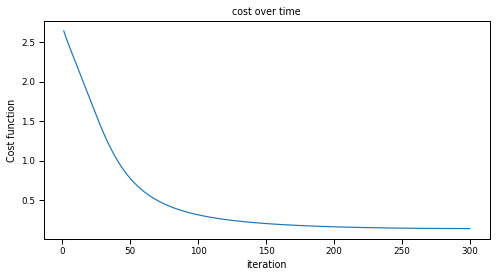

In [665]:
def plot_cost_over_time(cost_list, iterations):
    sns.set_context('paper')
    fig = plt.figure(figsize=(8,4))
    ax = sns.lineplot(np.linspace(1,iterations,iterations),cost_list)
    ax.set_title('cost over time')
    ax.set_ylabel('Cost function')
    ax.set_xlabel('iteration')
    plt.show()

plot_cost_over_time(cost_softmax_binary, iterations_SM)

Alright, does it predict things correctly?

In [668]:
pd.DataFrame(dict_of_FP_values_softmax_binary['A3'])

,0,1,2,3,4,5,6,7,8,9,...,12655,12656,12657,12658,12659,12660,12661,12662,12663,12664
0,0.996416,0.016527,0.015603,0.188581,0.004322,0.240488,0.024664,0.39057,0.124141,0.991152,...,0.700934,0.997093,0.004857,0.018948,0.055874,0.999089,0.007634,0.008252,0.998145,0.001177
1,0.003584,0.983473,0.984397,0.811419,0.995678,0.759512,0.975336,0.60943,0.875859,0.008848,...,0.299066,0.002907,0.995143,0.981052,0.944126,0.000911,0.992366,0.991748,0.001855,0.998823


In [683]:
def softmax_predictions(dict_of_FP_values_softmax, y_train_pre_hot):
    predictions_softmax = dict_of_FP_values_softmax['A3'].T
    list_of_predictions = []
    for row in predictions_softmax:
        max = np.amax(row)
        for idx,col in enumerate(row):
            if col == max:
                list_of_predictions.append(idx)
                break

    #ok so we need now to compare the list of predcitions to the y values.list_of_prediction
    correct = 0
    incorrect = 0
    for prediction, true in zip(list_of_predictions,y_train_pre_hot[0]):
        if prediction == true:
            correct +=1
        else:
            incorrect +=1 

    print(f'correct: {correct}\nincorrect: {incorrect}')
softmax_predictions(dict_of_FP_values_softmax_binary, y_train_binary)

correct: 4581
incorrect: 8084


Now trying with three classes


[1, 0, 2]
(784, 18623)
Weights matrices
W1 (80, 784)
B1 (80, 1)
W2 (80, 80)
B2 (80, 1)
W3 (3, 80)
B3 (3, 1)
iteration: 0
cost: 10.916867459982758
iteration: 100
cost: 1.596896074849333
iteration: 200
cost: 1.1954666847042974
iteration: 300
cost: 1.0107164525473151
iteration: 400
cost: 0.9030669056311865
iteration: 500
cost: 0.7773280747690606
iteration: 600
cost: 0.6869191754761516
iteration: 700
cost: 0.6215460826923921
iteration: 800
cost: 0.5494349138379001
iteration: 900
cost: 0.4946697477276433
correct: 15305
incorrect: 3318
/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


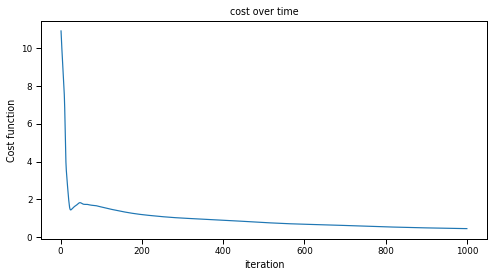

In [691]:
#get three classes
x_train_three, x_test_three, y_train_three, y_test_three = reduced_form(y_train, y_test, x_train, x_test, [1,0,2])
#create one hot encoding
y_train_three_one_hot, y_test_three_one_hot = create_one_hot_train_and_test(y_train_three, y_test_three)

#decide on learning rate and iterations
learning_rate = 0.07 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations_three = 1000

#run loop
cost_softmax_three, dict_of_FP_values_softmax_three, dict_of_weights_softmax_three = soft_max_iteration(learning_rate, iterations_three, x_train_three, y_train_three_one_hot)

#train set predictions
softmax_predictions(dict_of_FP_values_softmax_three, y_train_three)

#plot cost
plot_cost_over_time(cost_softmax_three, iterations_three)



[1, 0, 2, 3, 4]
(784, 30596)
Weights matrices
W1 (80, 784)
B1 (80, 1)
W2 (80, 80)
B2 (80, 1)
W3 (5, 80)
B3 (5, 1)
correct: 19667
incorrect: 10929
/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


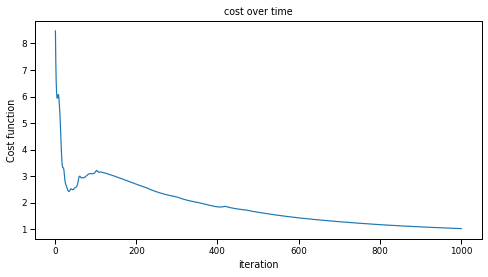

In [693]:
#get five classes
x_train_five, x_test_five, y_train_five, y_test_five = reduced_form(y_train, y_test, x_train, x_test, [1,0,2,3,4])
#create one hot encoding
five_y_train_one_hot, five_y_test_one_hot = create_one_hot_train_and_test(y_train_five, y_test_five)

#decide on learning rate and iterations
learning_rate = 0.1 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations_five = 1000

#run loop
cost_softmax_five, dict_of_FP_values_softmax_five, dict_of_weights_softmax_five = soft_max_iteration(learning_rate, iterations_five, x_train_five, five_y_train_one_hot)

#train set predictions
softmax_predictions(dict_of_FP_values_softmax_five, y_train_five)

#plot cost
plot_cost_over_time(cost_softmax_five, iterations_five)

[1, 0, 2, 3, 4, 5, 6, 7, 8, 9]
(784, 60000)
Weights matrices
W1 (80, 784)
B1 (80, 1)
W2 (80, 80)
B2 (80, 1)
W3 (10, 80)
B3 (10, 1)
correct: 9425
incorrect: 50575
/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


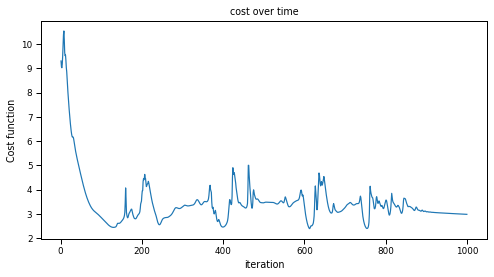

In [694]:
#get al classes
x_train_all, x_test_all, y_train_all, y_test_all = reduced_form(y_train, y_test, x_train, x_test, [1,0,2,3,4,5,6,7,8,9])
#create one hot encoding
all_y_train_one_hot, all_y_test_one_hot = create_one_hot_train_and_test(y_train_all, y_test_all)

#decide on learning rate and iterations
learning_rate = 0.1 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations_all = 1000

#run loop
cost_softmax_all, dict_of_FP_values_softmax_all, dict_of_weights_softmax_all = soft_max_iteration(learning_rate, iterations_all, x_train_all, all_y_train_one_hot)

#train set predictions
softmax_predictions(dict_of_FP_values_softmax_all, y_train_all)

#plot cost
plot_cost_over_time(cost_softmax_all, iterations_all)

#Redefining functions to try more hidden layers

In [746]:
type([x_train_flat.shape[0]])

list

In [751]:
#Initialising weights
def init_weights_flexible(x_train_flat, array_of_layers,y_train):
    np.random_state = 112
    size_of_layer = [x_train_flat.shape[0]] + array_of_layers + [y_train.shape[0]]
    dict_of_weights = {}

    for layer in range(len(size_of_layer) - 1):
        dict_of_weights[f"W{layer+1}"] = np.random.randn(size_of_layer[layer+1],size_of_layer[layer])
        dict_of_weights[f"B{layer+1}"] = np.random.randn(size_of_layer[layer+1],1)
    #Print the sizes of the matrix
    print(f"Weights matrices")
    for name, matrix in dict_of_weights.items():
        print(name, matrix.shape)
    return dict_of_weights

layers_test = [100,100,50,50]
dict_of_weights = init_weights_flexible(x_train_all, layers_test, all_y_train_one_hot)

Weights matrices
W1 (100, 784)
B1 (100, 1)
W2 (100, 100)
B2 (100, 1)
W3 (50, 100)
B3 (50, 1)
W4 (50, 50)
B4 (50, 1)
W5 (10, 50)
B5 (10, 1)


{'W1': array([[ 2.44059521, -0.16270368,  1.199702  , ..., -1.3872182 ,
          0.88229415, -1.86273326],
        [ 2.14680421, -1.00931627, -0.04931785, ...,  0.68553117,
          0.02815151, -0.22546649],
        [-1.7545047 ,  0.88090551, -0.14975293, ..., -1.13244888,
          0.22264381, -0.65960658],
        ...,
        [ 0.09457242, -0.41737069,  0.7534414 , ..., -0.94022522,
         -0.59622049,  1.24318917],
        [ 1.75815973, -0.85153944,  1.99104251, ...,  0.62846954,
          0.12275656,  0.10238974],
        [ 0.02928591, -1.07872266,  0.86047719, ..., -0.07559914,
         -0.49757167,  0.03498698]]),
 'B1': array([[-6.17846168e-04],
        [-1.29865488e+00],
        [-6.42779545e-01],
        [-6.34980898e-01],
        [ 1.01136477e+00],
        [ 5.68877697e-01],
        [ 6.18585677e-01],
        [-5.95689360e-01],
        [ 1.10454890e+00],
        [ 1.59907528e+00],
        [ 1.50201049e+00],
        [ 6.49088324e-01],
        [ 9.96287628e-01],
        [ 

## END OF DOCUMENT

Below here are just copy and paste from functions defined above, pasted here for ease of viewing when debugging

In [ ]:
##just for reference back prop one layer

def back_prop_one_layer_from_A_to_previous_A(cost_of_that_A, Z, prev_A,W):    
        #going back from A to z
        dAn_dZn = np.exp(-Z) / ((1+np.exp(-Z))**2)
        dC_dZn = cost_of_that_A * dAn_dZn
        
        #get diffs at that layer
        dZn_dWn = prev_A
        dZn_dBn = np.zeros_like(Z) + 1

        #combien to get useful differentials
        dC_dWn = dC_dZn @ dZn_dWn.T
        dC_dBn = np.sum(dC_dZn @ dZn_dBn.T,axis=1,keepdims=True) / dZn_dBn.shape[1]

        #and then get the previous layer cost fuctions
        dZn_dA_minus_one = W
        dC_dA_minus_one = (dC_dZn.T @ dZn_dA_minus_one).T

        return dC_dWn, dC_dBn, dC_dZn, dC_dA_minus_one

In [ ]:
##just for reference forwardprop.

def sigmoid(x):
    return (1/(1+np.exp(-x)))

dict_of_FP_values = {}
#FORWARD PROPOGATION
def sigmoid_forward_prop(previous_a, W, B):
    Z = W @ previous_a + B
    next_A = sigmoid(Z)
    return Z, next_A



In [ ]:
#just putting this here for reference / remidner.
'''def gradient_descent_softmax(learning_rate, dict_of_weights, differentiat_dict):
    
    #we have dictionaries for the weights and the differentials, which we should be able to use quite easily here. They are also in order so we can kind of cheat... but let's not 
    for key, value in dict_of_weights.items():
        dict_of_weights[key] += -learning_rate * differentiat_dict[f'd{key}']
    
    
learning_rate = 0.1  #no idea if this is a good learning rate
gradient_descent(learning_rate, dict_of_weights, differentiat_dict)'''